In [0]:
from google.colab import files
import os
import pandas as pd
import numpy as np

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [243]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [244]:
!ls drive/'My Drive'/'hack'/changelenge

CUP_IT_test_data.csv   preproc_train.csv      time-series_features
CUP_IT_train_data.csv  relevant_features.txt
hack21.ipynb	       test_data_preproc.csv


Для работы на другом устройстве необходимо изменить путь к данным

In [0]:
path = "drive/My Drive/hack/changelenge/"

In [0]:
# loading train data to DataFrame
dataset = pd.read_csv(path + "CUP_IT_train_data.csv", comment='#')

In [0]:
dataset['dlk_cob_date'] = pd.to_datetime(dataset['dlk_cob_date'])
# Сортировка 
dataset.sort_values(['cif_id', 'dlk_cob_date'], inplace=True)

## Замена NaN'ов

In [248]:
# Пример категориальной сырой фичи с пропусками об уровне образования
# является копией столбца cu_eduaction_level
dataset.cu_education_level.unique()

array(['02. Среднее профессиональное', '03. Высшее', '01. Среднее', nan,
       '04. Второе высшее, ученая степень'], dtype=object)

Функция для замены всех нанов в датасете

In [0]:
def fill_bank_na(input_df):
  fill_age(input_df)
  fill_sms(input_df)
  fill_educ(input_df)
  fill_credits(input_df)
  fill_debits(input_df)
  fill_replace_work_areas(input_df)
  fill_replace_work_levels(input_df)

In [0]:
def fill_age(dataset):
  dataset.cu_age.mask(dataset['cu_age'] == -100, dataset.cu_age.median(), axis=0,
                    inplace=True)
fill_age(dataset)

In [0]:
# Replace all -100 in sms column for -1
def fill_sms(dataset):
  dataset['cur_qnt_sms'].mask(dataset['cur_qnt_sms'] == -100.,
                                         0, inplace=True)
fill_sms(dataset)

In [0]:
# Заменим отсутствующие данные по образованию -100 на его отстутствие 0
# Возможно лучше будет заменить на медиану 3
def fill_educ(dataset):
  dataset.cu_eduaction_level.mask(dataset['cu_eduaction_level'] == -100, 
                                  dataset['cu_eduaction_level'].median(), axis=0,
                                  inplace=True)
  # Ручная замена NaNов, да это жестко
  value_for_replace = '03. Высшее' # вроде как медиана
  dataset.cu_education_level.fillna(value_for_replace, axis=0, inplace=True)
fill_educ(dataset)

In [0]:
# Замена Nan в кредитных счетах на 0
def fill_credits(dataset):
  dataset['cc_balance'].fillna(0., inplace=True)
  dataset['cl_balance'].fillna(0., inplace=True)
  dataset['ml_balance'].fillna(0., inplace=True)
  dataset['pl_balance'].fillna(0., inplace=True)
fill_credits(dataset)

In [0]:
# Замена Nan в кредитных счетах на 0
def fill_debits(dataset):
  dataset['td_volume'].fillna(0., inplace=True)
  dataset['ca_volume'].fillna(0., inplace=True)
  dataset['sa_volume'].fillna(0., inplace=True)
  dataset['mf_volume'].fillna(0., inplace=True)
fill_debits(dataset)

In [0]:
# Все отрасли работы и количество людей по ним
def find_all_work_areas(dataset):
  return dataset.loc[:,['cif_id', 'cu_empl_area']]\
                    .groupby('cu_empl_area',
                             as_index=False).count().sort_values('cif_id')

In [256]:
# Заменим все малочисленные направления работы и NaN'ы в графе отрасли на
def fill_replace_work_areas(dataset):
  work_areas = find_all_work_areas(dataset)
  # значение = 'ДРУГОЕ'
  default_empl_area = 'ДРУГОЕ'
  # Пороговое значение для отнесения профессии к категории Другое 36 месяцев
  empl_threshold = 36 # Нерепрезентивная выборка
  print('Удаленные отрасли:')
  sum_1 = dataset['cu_empl_area'].nunique()
  for area in work_areas.values:
    if area[1] < empl_threshold:
      dataset['cu_empl_area'].mask(dataset['cu_empl_area'] == area[0],
                                  default_empl_area, inplace=True)
      print(area)
  sum_2 = dataset['cu_empl_area'].nunique()
  print(f'Удалено {sum_1 - sum_2} отраслей.')
  # Замена нанов
  dataset['cu_empl_area'].fillna(default_empl_area, inplace=True)
  print(f'Осталось: {sum_2} отраслей.')

# Apply func
fill_replace_work_areas(dataset)

Удаленные отрасли:
['карнизы, жалюзи - торговля' 1]
['Сдача нежилого помещения в аренду' 1]
['торговля продуктами питания' 1]
['О' 1]
['Инвестиционная' 1]
['ритуальные услуги' 1]
['Торговля оргтехникой' 1]
['Столярное производство' 2]
['производство, продажа' 2]
['разработка, внедрение информ.систем' 2]
['Химическая продукция' 2]
['Международные перевозки' 2]
['Управление сетью магазинов' 2]
['Ритуальные услуги' 3]
['сервисная нефтяная компания' 3]
['Производство алкогольных напитков' 3]
['реклама и дизайн' 3]
['Транспортно-экспортные услуги' 4]
['Театр, кино' 4]
['обслуживание техники' 4]
['спорт, обучение' 4]
['Турбостроение-машиностроение' 5]
['Информационные услуги (справочная служба)' 5]
['Инженерно-техническое предприятие' 6]
['Издательский дом' 7]
['Другое охрана' 7]
['агенстство по подбору персонала' 7]
['Спутниковая связь' 7]
['Промышленность' 8]
['поставка насосного оборудования' 8]
['световое, звуковое оборудование' 8]
['Автогрузовые перевозки' 9]
['Рекламное агенство' 9]
['

In [0]:
# Все должности и количество людей, которые их занимают
def find_all_work_levels(dataset):
  return dataset.loc[:,['cif_id', 'cu_empl_level']]\
                      .groupby('cu_empl_level',
                              as_index=False).count().sort_values('cif_id')
# work_levels.cu_empl_level.unique()

In [258]:
# Заменим все малочисленные направления работы и NaN'ы в графе отрасли на
# значение = 'Qualified staff'
def fill_replace_work_levels(dataset):
  work_levels = find_all_work_levels(dataset)
  default_empl_level = work_levels.sort_values('cif_id').iloc[-1,0]
  # Пороговое значение для отнесения профессии к категории Другое 36 месяцев
  empl_lvl_threshold = 36 # Нерепрезентивная выборка
  print('Удаленные направления:')
  sum_1 = dataset['cu_empl_level'].nunique()
  for area in work_levels.values:
    if area[1] < empl_lvl_threshold:
      dataset['cu_empl_level'].mask(dataset['cu_empl_level'] == area[0],
                                  default_empl_level, inplace=True)
      print(area)
  sum_2 = dataset['cu_empl_level'].nunique()
  print(f'Удалено {sum_1 - sum_2} профессий.')
  # Замена нанов
  dataset['cu_empl_level'].fillna(default_empl_level, inplace=True)
  print(f'Осталось: {sum_2} профессий')
fill_replace_work_levels(dataset)

Удаленные направления:
['Qualifie d staff' 1]
['U' 1]
['менеджер' 2]
['Директор' 3]
['ассистент' 7]
['Other - учащаяся' 7]
['пРОДАВЕЦ-КОНСУЛЬТАНТ' 10]
['начальник отдела' 12]
['начальник отдела продаж' 12]
['АО ТПК' 12]
['-' 24]
Удалено 11 профессий.
Осталось: 18 профессий


Просмотрим теперь все столбцы на наличие нанов

In [0]:
def search_nan(dataset):
  k = 0
  for column in dataset:
    nans = dataset[column].isna().sum()
    if nans:
      print(f"В столбце {column} - {nans} пропущенных значений!")
      k += 1
  if not k:
    print("Роскошно, нанов нет!")
    return 0
  else:
    print(f"Разуй глаза, у тебя {k} параметра(ов) с нанами!")
    return k

In [260]:
search_nan(dataset)

Роскошно, нанов нет!


0

### Просмотр датасета

In [0]:
# test_data = pd.read_csv("drive/My Drive/hack/changelenge/CUP_IT_test_data.csv", comment='#', sep=';')

In [262]:
# Мое дерьмо
def restart_dataset_light():
  global dataset_light
  dataset_light = dataset.loc[:, ['cif_id', 'gi_smooth_3m', 'dlk_cob_date']]
restart_dataset_light()
dataset_light.head(5)

,cif_id,gi_smooth_3m,dlk_cob_date
1342694,1001,70.994186,2018-01-31
1342693,1001,-6.005108,2018-02-28
1342691,1001,114.989605,2018-03-31
1342690,1001,147.408528,2018-04-30
1342692,1001,185.987934,2018-05-31


In [0]:
work_areas = dataset.cu_empl_area.unique()

In [264]:
dataset.describe()

,cif_id,gi_smooth_3m,cu_gender,payroll_f,cur_quantity_pl,cur_quantity_mort,cur_quantity_cc,cur_quantity_deposits,cur_quantity_dc,cur_quantity_accounts,cur_quantity_saccounts,cur_quantity_mf,cc_balance,cl_balance,ml_balance,pl_balance,td_volume,ca_volume,sa_volume,mf_volume,dc_cash_spend_v,dc_cash_spend_c,cc_cash_spend_v,cc_cash_spend_c,dc_pos_spend_v,dc_pos_spend_c,cc_pos_spend_v,cc_pos_spend_c,ca_f,rc_session_qnt_cur_mon,cur_qnt_sms,active,standalone_dc_f,standalone_payroll_dc_f,standalone_nonpayroll_dc_f,salary,cu_age,cu_mob,cu_empl_cur_dur_m,is_married,cu_eduaction_level
count,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06,4.161783e+06
mean,2.561075e+05,4.017062e+01,5.401891e-01,2.629013e-01,5.006443e-01,4.335161e-02,7.480239e-01,3.827206e-03,8.437559e-01,1.303357e+00,8.238296e-02,3.780351e-03,-4.005089e+02,-5.996150e+01,-1.631087e+03,-3.330171e+03,2.967350e+01,3.252812e+02,6.879363e+01,6.641454e+00,2.750245e+02,1.077176e+00,1.440580e+01,7.544891e-02,1.406890e+02,7.691187e+00,8.317771e+01,2.867909e+00,9.747032e-01,4.812689e+00,6.187925e-01,9.299317e-01,4.750651e-01,6.241484e-02,4.126503e-01,1.311355e+03,3.999307e+01,8.443463e+01,9.698892e+01,6.319267e-01,2.749776e+00
std,1.473086e+05,5.402052e+01,4.983823e-01,4.402093e-01,5.919211e-01,2.044246e-01,9.918981e-01,6.569771e-02,5.793352e-01,6.978141e-01,3.310817e-01,8.327314e-02,1.127062e+03,5.274844e+02,9.517451e+03,5.984795e+03,1.382057e+03,1.537483e+03,9.284936e+02,1.836912e+02,1.113230e+03,2.304361e+00,1.419917e+02,5.081492e-01,4.294125e+02,1.746881e+01,3.525784e+02,1.048502e+01,1.570252e-01,1.389500e+01,6.737776e-01,2.552621e-01,4.993779e-01,2.419075e-01,4.923110e-01,1.084482e+03,9.435202e+00,5.128387e+01,7.352383e+01,4.822814e-01,7.149400e-01
min,1.001000e+03,-1.199554e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.431041e+04,-2.578268e+04,-1.298236e+06,-7.538658e+04,0.000000e+00,-7.092194e+03,-5.575680e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00,1.600000e+01,1.200000e+01,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.285530e+05,4.179842e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.766939e+03,0.000000e+00,4.224000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.308000e+02,3.200000e+01,5.200000e+01,4.600000e+01,0.000000e+00,2.000000e+00
50%,2.559730e+05,2.197043e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.389760e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.091502e+03,3.800000e+01,7.300000e+01,7.900000e+01,1.000000e+00,3.000000e+00
75%,3.837020e+05,5.714864e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000

In [265]:
work_areas

array(['Строительство, недвижимость', 'ДРУГОЕ',
       'ПРОИЗВОДСТВО, ДОБЫВАЮЩАЯ ПРОМЫШЛЕННОСТЬ',
       'ИНФОРМАЦИОННЫЕ ТЕХНОЛОГИИ', 'ТОРГОВЛЯ', 'ЗДРАВООХРАНЕНИЕ',
       'Туризм, развлечения, ресторанный бизнес',
       'Финансы, управляющие компании, банки', 'ТРАНСПОРТ, ЛОГИСТИКА',
       'ЮРИДИЧЕСКИЕ УСЛУГИ', 'PR, маркетинг, СМИ', 'Наука, образование',
       'СТРАХОВАНИЕ', 'Государственная служба',
       'ТУРИЗМ, РАЗВЛЕЧЕНИЯ, РЕСТОРАННЫЙ БИЗНЕС', 'Подбор персонала',
       'СТРОИТЕЛЬСТВО, НЕДВИЖИМОСТЬ'], dtype=object)

In [266]:
dataset_light.sample(5)

,cif_id,gi_smooth_3m,dlk_cob_date
270714,294043,41.562508,2018-11-30
558964,448099,0.160538,2018-05-31
2248721,433730,-1.947522,2018-09-30
424701,258281,-0.018306,2018-09-30
2081372,370907,14.576080,2018-10-31


In [267]:
dataset.dtypes

cif_id                                 int64
dlk_cob_date                  datetime64[ns]
gi_smooth_3m                         float64
big_city                              object
cu_gender                              int64
cu_education_level                    object
cu_empl_area                          object
cu_empl_level                         object
payroll_f                              int64
cur_quantity_pl                        int64
cur_quantity_mort                      int64
cur_quantity_cc                        int64
cur_quantity_deposits                  int64
cur_quantity_dc                        int64
cur_quantity_accounts                  int64
cur_quantity_saccounts                 int64
cur_quantity_mf                        int64
cc_balance                           float64
cl_balance                           float64
ml_balance                           float64
pl_balance                           float64
td_volume                            float64
ca_volume 

In [0]:
# test_data.cu_eduaction_level.unique()

## Создание фичей и разбиение по категориям

### Создание возрастных категорий



Для начала оценим какие возрастные группы превалируют в датасете, для чего посмотрим процентили

In [269]:
dataset.cu_age.quantile([0.1 * i for i in range(1, 10)])

0.1    29.0
0.2    31.0
0.3    33.0
0.4    36.0
0.5    38.0
0.6    41.0
0.7    45.0
0.8    49.0
0.9    54.0
Name: cu_age, dtype: float64

Заменим отсутствующие значения на медианное

In [0]:
# dataset.cu_age.mask(dataset['cu_age'] == -100, dataset.cu_age.median(), axis=0,
#                     inplace=True)

In [271]:
# Проверка
dataset['cu_age'].unique()

array([56., 57., 48., 49., 52., 53., 54., 34., 35., 27., 28., 30., 31.,
       26., 36., 37., 47., 33., 29., 44., 45., 32., 55., 50., 42., 43.,
       25., 24., 40., 41., 46., 62., 58., 59., 60., 61., 38., 39., 51.,
       63., 65., 64., 23., 22., 66., 20., 21., 67., 68., 69., 70., 71.,
       73., 74., 72., 81., 82., 19., 75., 17., 76., 77., 16., 89., 90.,
       18.])

Из распределения видно что большинтсво пользователей банка это клиенты в возрасте от 30 до 45 лет, больше 50%

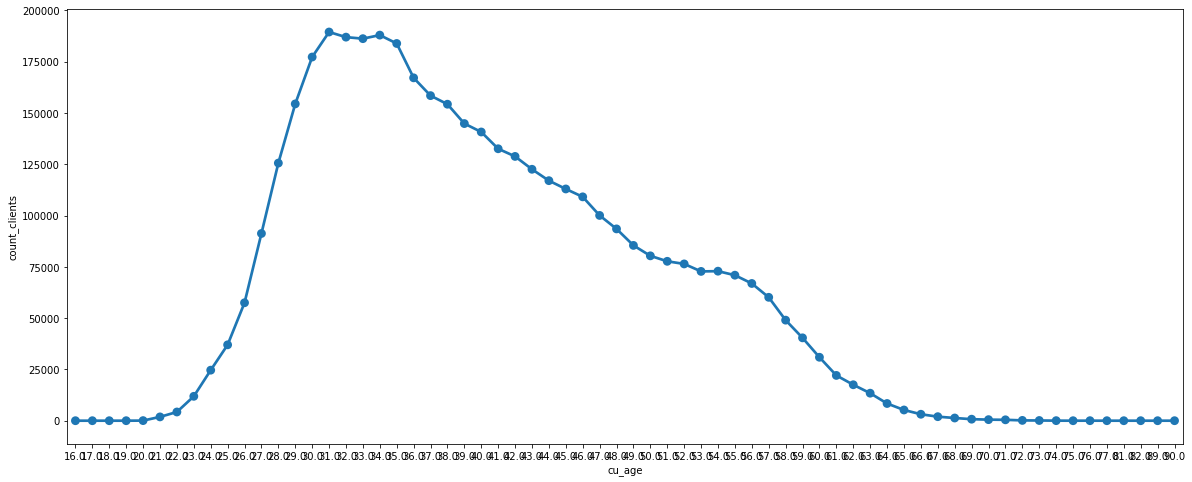

In [272]:
# Построим график распределения возрастов
plt.figure(figsize=(20, 8))
ages = dataset.groupby('cu_age', as_index=False).agg({'cif_id': 'count'}).rename({'cif_id': 'count_clients'}, axis=1)
sns.pointplot(ages['cu_age'], ages['count_clients'])

Разобьем выборку исходя из известных теперь данных на 3 группы:
  - Молодые люди, выпускники, студенты 16 - 30 ~ 15-20%
  - Основные клиенты, работающие с банком 31 - 45 ~ 50 %
  - Люди за 45 46 - 63 ~ 20%
  - Пенсионеры ~ 10%

In [0]:
criteria = [ages.cu_age.between(16, 30),
            ages.cu_age.between(31, 45),
            ages.cu_age.between(46, 63),
            ages.cu_age.between(64, 120)]
values = [1, 2, 3, 4]

### Замена возраста на категории
Напишем функцию для аггрегации данных по возрасту и создания категорий

In [0]:
age_groups = {
    1: range(16, 31),
    2: range(31, 45),
    3: range(45, 64),
    4: range(64, 121)
}
def get_age_category(age):
  for cat, gap in age_groups.items():
    if age in gap:
      return cat
  return 2

In [0]:
# ages['groups'] = np.select(criteria, values, 2)

In [0]:
# ages.head(7)

In [0]:
del ages

## Создание датасета для обучения


Для начала создадим датасета с группировкой по клиентами аггрегацией по следующим признакам:
  - средний и суммарный доходы
  - количество месяцев в банке за 2018 год
  - первый и последний месяцы 2018 года
  - Уровень образования 0 - 4
  - количество месяце в банке за все время

In [0]:
# функция для аггрегации - берет последний параметр
last = lambda x: x.iloc[-1]

In [0]:
# threshold for train and test split 7th month of 2018 year
threshold = pd.to_datetime('2018-07-31T00:00:00.000000000')

In [0]:
dataset_train = dataset.query('dlk_cob_date < @threshold')

In [281]:
# Проверим сработала лли отсечка
dataset_train.dlk_cob_date.max()

Timestamp('2018-06-30 00:00:00')

In [0]:
# Список фичей для удаления перед аггрегацией
useless_feats = [
                #  'cu_education_level',
                #  'cu_empl_area',
                #  'cu_empl_level',
                 'dlk_cob_date'
]
balance_agg_funcs = ['mean', 'max', 'min']
credits_agg_funcs = [last, 'max']
deposit_agg_funcs = ['mean', 'max']
cards_spend_agg_funcs = ['mean', 'max']
cards_count_agg_funcs = ['mean']
categorical_agg_func = [last]
age_agg_funcs = [last]

In [0]:
# Теперь агрегируем все данные для обучающей выборки
dataset_train = dataset_train\
                        .drop(useless_feats, axis=1)\
                        .groupby('cif_id', as_index=False)\
                        .agg({#'dlk_cob_date': [last, 'max', 'min', 'count'],
                              'gi_smooth_3m': ['mean', 'sum'],
                              'big_city': [last,],
                              'cu_gender': [last],
                              'payroll_f': [last],
                              'cur_quantity_pl': [last],
                              'cur_quantity_mort': [last, 'mean'],
                              'cur_quantity_cc': [last, 'mean'],
                              'cur_quantity_deposits': [last, 'mean'],
                              'cur_quantity_dc': [last, 'mean'],
                              'cur_quantity_accounts': [last, 'mean'],
                              'cur_quantity_saccounts': [last, 'mean'],
                              'cur_quantity_mf': [last, 'mean'],
                              'cc_balance': balance_agg_funcs,
                              'cl_balance': credits_agg_funcs,
                              'ml_balance': credits_agg_funcs,
                              'pl_balance': credits_agg_funcs,
                              'td_volume': deposit_agg_funcs,
                              'ca_volume': deposit_agg_funcs,
                              'sa_volume': deposit_agg_funcs,
                              'mf_volume': deposit_agg_funcs,
                              'dc_cash_spend_v': cards_spend_agg_funcs,
                              'dc_cash_spend_c': cards_count_agg_funcs,
                              'cc_cash_spend_v': cards_spend_agg_funcs,
                              'cc_cash_spend_c': cards_count_agg_funcs,
                              'dc_pos_spend_v': cards_spend_agg_funcs,
                              'dc_pos_spend_c': cards_count_agg_funcs,
                              'cc_pos_spend_v': cards_spend_agg_funcs,
                              'cc_pos_spend_c': cards_count_agg_funcs,
                              'ca_f': categorical_agg_func,
                              'rc_session_qnt_cur_mon': [last, 'mean'],
                              'cur_qnt_sms': ['mean'],
                              'active': [last, 'mean'],
                              'standalone_dc_f': [last],
                              'standalone_payroll_dc_f': categorical_agg_func,
                              'standalone_nonpayroll_dc_f': categorical_agg_func,
                              'salary': balance_agg_funcs,
                              'cu_age': age_agg_funcs,
                              'cu_mob': [last],
                              'cu_empl_cur_dur_m': [last],
                              'is_married': categorical_agg_func,
                              'cu_eduaction_level': categorical_agg_func,
                              'cu_education_level': categorical_agg_func,
                              'cu_empl_area': categorical_agg_func,
                              'cu_empl_level': categorical_agg_func
                              })

In [0]:
# Уберем двойные колонки
dataset_train.columns = ["_".join(x) for x in dataset_train.columns.ravel()]

In [285]:
# Проверка размерности
dataset_train.shape

(364617, 70)

In [0]:
# Добавим переменные для первого и последнего месяцев 2018 года
first_month = dataset['dlk_cob_date'].min()
last_mont = dataset['dlk_cob_date'].max()

### Добавление колонки ухода клиента

Добавим колонку в которой будет храниться значение покинул ли клиент банк или нет и заполним ее, в качестве критерия будем последний месяц транзакции, если это не последний месяц года, как в большинтве случаев то значит что клиент покинул банк

In [0]:
# Оставим до лучших времен
# dataset_train['droped'] = 0
# dataset_train['droped'] = dataset_train['droped']\
#                           .mask(
#                           dataset_train['dlk_cob_date_max'] < last_mont,
#                           1, axis=0)

In [0]:
# dataset = dataset.merge(dataset_train.loc[:,['cif_id_', 'droped']], left_on='cif_id', right_on='cif_id_', how='outer')

In [289]:
dataset_train.index = dataset_train['cif_id_']
dataset_train.sample(5)

,cif_id_,gi_smooth_3m_mean,gi_smooth_3m_sum,big_city_<lambda>,cu_gender_<lambda>,payroll_f_<lambda>,cur_quantity_pl_<lambda>,cur_quantity_mort_<lambda_0>,cur_quantity_mort_mean,cur_quantity_cc_<lambda_0>,cur_quantity_cc_mean,cur_quantity_deposits_<lambda_0>,cur_quantity_deposits_mean,cur_quantity_dc_<lambda_0>,cur_quantity_dc_mean,cur_quantity_accounts_<lambda_0>,cur_quantity_accounts_mean,cur_quantity_saccounts_<lambda_0>,cur_quantity_saccounts_mean,cur_quantity_mf_<lambda_0>,cur_quantity_mf_mean,cc_balance_mean,cc_balance_max,cc_balance_min,cl_balance_<lambda_0>,cl_balance_max,ml_balance_<lambda_0>,ml_balance_max,pl_balance_<lambda_0>,pl_balance_max,td_volume_mean,td_volume_max,ca_volume_mean,ca_volume_max,sa_volume_mean,sa_volume_max,mf_volume_mean,mf_volume_max,dc_cash_spend_v_mean,dc_cash_spend_v_max,dc_cash_spend_c_mean,cc_cash_spend_v_mean,cc_cash_spend_v_max,cc_cash_spend_c_mean,dc_pos_spend_v_mean,dc_pos_spend_v_max,dc_pos_spend_c_mean,cc_pos_spend_v_mean,cc_pos_spend_v_max,cc_pos_spend_c_mean,ca_f_<lambda>,rc_session_qnt_cur_mon_<lambda_0>,rc_session_qnt_cur_mon_mean,cur_qnt_sms_mean,active_<lambda_0>,active_mean,standalone_dc_f_<lambda>,standalone_payroll_dc_f_<lambda>,standalone_nonpayroll_dc_f_<lambda>,salary_mean,salary_max,salary_min,cu_age_<lambda>,cu_mob_<lambda>,cu_empl_cur_dur_m_<lambda>,is_married_<lambda>,cu_eduaction_level_<lambda>,cu_education_level_<lambda>,cu_empl_area_<lambda>,cu_empl_level_<lambda>
cif_id_,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
450108,450108,9.509237,57.055423,OTH,0,0,0,0,0.0,2,2.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,-288.76872,-253.53432,-323.07432,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,1,0,0.000000,1.0,1,1.0,0,0,0,600.00000,600.00000,600.00000,46.0,67,321.0,0,3,03. Высшее,"Наука, образование",QUALIFIED STAFF
253810,253810,26.908871,161.453223,OTH,0,0,1,0,0.0,0,0.0,0,0.0,1,1.0,1,1.0,0,0.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,-3876.27264,-3876.27264,0.0,0.0,48.91352,87.44304,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,1,0,0.000000,0.0,1,1.0,1,0,1,600.00000,600.00000,600.00000,43.0,51,117.0,1,3,03. Высшее,Государственная служба,QUALIFIED STAFF
85387,85387,1.653650,1.653650,MSK,0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,2,2.0,0,0.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,1,0,0.000000,0.0,1,1.0,0,0,0,1144.49946,1144.49946,1144.49946,27.0,54,54.0,0,3,03. Высшее,ДРУГОЕ,QUALIFIED STAFF
85262,85262,9.861176,59.167053,MLN,0,0,0,0,0.0,0,0.0,0,0.0,1,1.0,1,1.0,0,0.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,1409.35040,1955.52000,0.0,0.0,0.0,0.0,641.8,2074.8,0.833333,0.0,0.0,0.0,5.36000,29.28000,0.666667,0.0,0.0,0.0,1,4,3.666667,1.0,1,1.0,0,0,0,1433.18400,1433.18400,1433.18400,30.0,86,86.0,0,3,03. Высшее,"ПРОИЗВОДСТВО, ДОБЫВАЮЩАЯ ПРОМЫШЛЕННОСТЬ",MIDDLE MANAGEMENT
122777,122777,31.269931,187.619583,MSK,1,0,1,0,0.0,1,1.0,0,0.0,1,1.0,1,1.0,0,0.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,-2411.23560,-2411.23560,0.0,0.0,86.55316,322.81152,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,49.91512,106.46616,5.000000,0.0,0.0,0.0,1,0,0.000000,1.0,1,1.0,1,0,1,2880.00000,2880.00000,2880.00000,43.0,52,24.0,0,3,03. Высшее,ТОРГОВЛЯ,MIDDLE MANAGEMENT


In [0]:
# dataset_train.loc[:, ['cu_eduaction_level_max', 'cif_id_']].groupby('cu_eduaction_level_max').count()

### Удаление клиентов находящихся в банке меньше 12 месяцев

In [0]:
dropped_clients = dataset.loc[:, ['cif_id', 'dlk_cob_date']]\
                        .groupby('cif_id', as_index=False)\
                        .agg({'dlk_cob_date': ['max', 'min', 'count']})

In [0]:
dropped_clients.columns = ["_".join(x) for x in dropped_clients.columns.ravel()]

In [293]:
useless_ids = dropped_clients.query('dlk_cob_date_count < 12')['cif_id_']
useless_ids.shape

(96885,)

In [0]:
# Очищаем созданный датасет с удаленными клиентами
del dropped_clients

Для удаления исп. следующу строку

In [0]:
# Удаление ненужных записей
dataset_train = dataset_train.drop(useless_ids, axis=0, errors='ignore')

In [296]:
# После удаления клиентов
dataset_train.shape

(299691, 70)

### Добавление и удаление фичей и кодирование объектов

#### Добавление колонки с возрастной категорией

In [0]:
dataset_train['age_category'] = dataset_train['cu_age_<lambda>'].apply(get_age_category)

### Преобразование текстовых фичей

Установка библиотеки для токенизации текста

In [298]:
!pip install pymorphy2

In [0]:
# Импорты для преобразования текстовых переменных в лэйблы
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

In [0]:
# Текстовые объекты (колонки) для преобразования 
obj_columns = [
               'big_city_<lambda>',
               'cu_education_level_<lambda>',
               'cu_empl_area_<lambda>',
               'cu_empl_level_<lambda>'
]

In [0]:
# Инициализация анализатора
morph = pymorphy2.MorphAnalyzer()
for obj in dataset_train:
  data = list()
  if obj in obj_columns:
    dataset_train['temp'] = dataset_train[obj].apply(lambda x: morph.parse(str(x))[0].normal_form)
    enc = preprocessing.OrdinalEncoder()
    enc.fit(dataset_train['temp'].values.reshape(-1, 1))
    dataset_train[obj] = enc.transform(dataset_train['temp'].values.reshape(-1, 1))[:, 0]

In [0]:
# Удалим временную колонку
dataset_train = dataset_train.drop('temp', axis=1)

In [303]:
dataset_train.sample(10)

,cif_id_,gi_smooth_3m_mean,gi_smooth_3m_sum,big_city_<lambda>,cu_gender_<lambda>,payroll_f_<lambda>,cur_quantity_pl_<lambda>,cur_quantity_mort_<lambda_0>,cur_quantity_mort_mean,cur_quantity_cc_<lambda_0>,cur_quantity_cc_mean,cur_quantity_deposits_<lambda_0>,cur_quantity_deposits_mean,cur_quantity_dc_<lambda_0>,cur_quantity_dc_mean,cur_quantity_accounts_<lambda_0>,cur_quantity_accounts_mean,cur_quantity_saccounts_<lambda_0>,cur_quantity_saccounts_mean,cur_quantity_mf_<lambda_0>,cur_quantity_mf_mean,cc_balance_mean,cc_balance_max,cc_balance_min,cl_balance_<lambda_0>,cl_balance_max,ml_balance_<lambda_0>,ml_balance_max,pl_balance_<lambda_0>,pl_balance_max,td_volume_mean,td_volume_max,ca_volume_mean,ca_volume_max,sa_volume_mean,sa_volume_max,mf_volume_mean,mf_volume_max,dc_cash_spend_v_mean,dc_cash_spend_v_max,dc_cash_spend_c_mean,cc_cash_spend_v_mean,cc_cash_spend_v_max,cc_cash_spend_c_mean,dc_pos_spend_v_mean,dc_pos_spend_v_max,dc_pos_spend_c_mean,cc_pos_spend_v_mean,cc_pos_spend_v_max,cc_pos_spend_c_mean,ca_f_<lambda>,rc_session_qnt_cur_mon_<lambda_0>,rc_session_qnt_cur_mon_mean,cur_qnt_sms_mean,active_<lambda_0>,active_mean,standalone_dc_f_<lambda>,standalone_payroll_dc_f_<lambda>,standalone_nonpayroll_dc_f_<lambda>,salary_mean,salary_max,salary_min,cu_age_<lambda>,cu_mob_<lambda>,cu_empl_cur_dur_m_<lambda>,is_married_<lambda>,cu_eduaction_level_<lambda>,cu_education_level_<lambda>,cu_empl_area_<lambda>,cu_empl_level_<lambda>,age_category
cif_id_,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
382065,382065,127.115946,762.695676,0.0,1,1,0,1,1.000000,2,1.333333,0,0.0,1,1.000000,1,1.0,0,0.0,0,0.0,-137.75720,0.88560,-423.91440,0.0,0.0,-43054.52928,-43054.52928,0.00000,0.00000,0.0,0.0,17.96576,48.52656,0.00000,0.00000,0.0,0.0,1671.6,3540.0,3.666667,0.0,0.0,0.0,102.54272,246.96672,14.166667,70.6524,423.9144,0.333333,1,19,13.500000,1.000000,1,1.0,0,0,0,1754.03744,1879.46400,1705.99200,33.0,29,30.0,1,3,2.0,10.0,11.0,2
346587,346587,23.649330,141.895980,1.0,0,1,0,0,0.000000,0,0.000000,0,0.0,1,1.000000,1,1.0,1,1.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.0,235.37232,771.13536,266.56576,387.10032,0.0,0.0,360.0,588.0,3.500000,0.0,0.0,0.0,683.35956,970.85208,18.000000,0.0000,0.0000,0.000000,1,0,0.833333,0.166667,1,1.0,1,1,0,1862.59880,1992.16776,1804.64064,47.0,151,151.0,1,2,1.0,10.0,2.0,3
441310,441310,20.986008,125.916046,2.0,0,0,1,0,0.000000,0,0.000000,0,0.0,0,0.000000,1,1.0,0,0.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,-1803.32232,-1803.32232,0.0,0.0,8.44656,11.54016,0.00000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0000,0.0000,0.000000,1,0,0.000000,0.000000,1,1.0,0,0,0,960.00000,960.00000,960.00000,52.0,18,135.0,0,3,2.0,10.0,10.0,3
160819,160819,55.721122,334.326730,2.0,0,0,1,0,0.000000,0,1.666667,0,0.0,1,1.000000,1,1.0,0,0.0,0,0.0,-15.83160,0.00000,-56.06952,0.0,0.0,0.00000,0.00000,-7127.08248,-7127.08248,0.0,0.0,63.94088,179.65248,0.00000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0000,0.0000,0.000000,1,0,0.000000,1.000000,1,1.0,1,0,1,864.00000,864.00000,864.00000,57.0,153,353.0,1,2,1.0,7.0,6.0,3
101672,101672,132.509818,795.058910,2.0,0,0,0,1,0.833333,2,1.666667,0,0.0,1,0.833333,1,1.0,0,0.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,-78250.86696,0.00000,0.00000,0.00000,0.0,0.0,209.88724,960.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0000,0.0000,0.000000,1,2,2.500000,0.000000,1,1.0,1,0,1,1716.10264,1878.95928,1634.67432,30.0,83,20.0,0,3,2.0,10.0,10.0,1
365543,365543,27.744924,166.469543,2.0,0,0,1,0,0.000000,0,0.000000,0,0.0,1,1.000000,1,1.0,0,0.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,-3360.57840,-3360.57840,0.0,0.0,2.80312,10.58088,0.00000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.0000,0.0000,0.000000,1,0,0.000000,1.000000,1,1.0,1,0,1,716.97744,716.97744,716.97744,31.0,61,86.0,0,3,2.0,13.0,10.0,2
63381,63381,0.006795,0.04

### Создание тестовых колонок

In [0]:
# Граница для тестовой выборки
test_threshold = pd.to_datetime('2018-06-30T00:00:00.000000000')

In [0]:
# Отбираем записи начиная с 7 месяца
dataset_test = dataset.loc[:,['cif_id', 'dlk_cob_date', 'gi_smooth_3m']]\
                      .query('dlk_cob_date < @test_threshold')\
                      .groupby('cif_id', as_index=False)\
                      .agg({'dlk_cob_date': ['max', 'min', 'count'],
                              'gi_smooth_3m': ['mean', 'sum']})

In [306]:
dataset_test.columns = ["_".join(x) for x in dataset_test.columns.ravel()]
dataset_test.head(5)

,cif_id_,dlk_cob_date_max,dlk_cob_date_min,dlk_cob_date_count,gi_smooth_3m_mean,gi_smooth_3m_sum
0,1001,2018-05-31,2018-01-31,5,102.675029,513.375145
1,1002,2018-05-31,2018-01-31,5,40.679868,203.399339
2,1004,2018-05-31,2018-01-31,5,0.164380,0.821898
3,1005,2018-05-31,2018-01-31,5,0.007933,0.039663
4,1007,2018-05-31,2018-01-31,5,1.643892,8.219458


In [0]:
# Удаляем клиентов которые провели в банке меньше 12 месяцев
dataset_test.index = dataset_test['cif_id_']
dataset_test = dataset_test.drop(useless_ids, axis=0, errors='ignore')

In [308]:
# Проверим на совпадение количество клиентов в тестовой и тренировочной выборках
print(dataset_test.shape, dataset_train.shape)

(299691, 6) (299691, 71)


In [309]:
dataset_test.columns

Index(['cif_id_', 'dlk_cob_date_max', 'dlk_cob_date_min', 'dlk_cob_date_count',
       'gi_smooth_3m_mean', 'gi_smooth_3m_sum'],
      dtype='object')

In [0]:
dataset_test = dataset_test\
                   .drop(['dlk_cob_date_max',
                   'dlk_cob_date_min',
                   'dlk_cob_date_count'], axis=1)

In [311]:
dataset_test = dataset_test\
                   .rename({'gi_smooth_3m_mean': 'mean_month_cltv',
                            'gi_smooth_3m_sum': 'sum_cltv'},
                           axis=1)
dataset_test.head()

,cif_id_,mean_month_cltv,sum_cltv
cif_id_,,,
1001,1001,102.675029,513.375145
1002,1002,40.679868,203.399339
1004,1004,0.164380,0.821898
1005,1005,0.007933,0.039663
1007,1007,1.643892,8.219458


## Финальный на данном этапе датасет для обучения

In [0]:
dataset_res = dataset_train.merge(dataset_test, how='inner', on=dataset_test.cif_id_)\
             .drop(['key_0', 'cif_id__y'], axis=1)\
             .rename({'cif_id__x': 'cif_id'}, axis=1)

In [313]:
# Взглянем на датасет
dataset_res.head(5)

,cif_id,gi_smooth_3m_mean,gi_smooth_3m_sum,big_city_<lambda>,cu_gender_<lambda>,payroll_f_<lambda>,cur_quantity_pl_<lambda>,cur_quantity_mort_<lambda_0>,cur_quantity_mort_mean,cur_quantity_cc_<lambda_0>,cur_quantity_cc_mean,cur_quantity_deposits_<lambda_0>,cur_quantity_deposits_mean,cur_quantity_dc_<lambda_0>,cur_quantity_dc_mean,cur_quantity_accounts_<lambda_0>,cur_quantity_accounts_mean,cur_quantity_saccounts_<lambda_0>,cur_quantity_saccounts_mean,cur_quantity_mf_<lambda_0>,cur_quantity_mf_mean,cc_balance_mean,cc_balance_max,cc_balance_min,cl_balance_<lambda_0>,cl_balance_max,ml_balance_<lambda_0>,ml_balance_max,pl_balance_<lambda_0>,pl_balance_max,td_volume_mean,td_volume_max,ca_volume_mean,ca_volume_max,sa_volume_mean,sa_volume_max,mf_volume_mean,mf_volume_max,dc_cash_spend_v_mean,dc_cash_spend_v_max,dc_cash_spend_c_mean,cc_cash_spend_v_mean,cc_cash_spend_v_max,cc_cash_spend_c_mean,dc_pos_spend_v_mean,dc_pos_spend_v_max,dc_pos_spend_c_mean,cc_pos_spend_v_mean,cc_pos_spend_v_max,cc_pos_spend_c_mean,ca_f_<lambda>,rc_session_qnt_cur_mon_<lambda_0>,rc_session_qnt_cur_mon_mean,cur_qnt_sms_mean,active_<lambda_0>,active_mean,standalone_dc_f_<lambda>,standalone_payroll_dc_f_<lambda>,standalone_nonpayroll_dc_f_<lambda>,salary_mean,salary_max,salary_min,cu_age_<lambda>,cu_mob_<lambda>,cu_empl_cur_dur_m_<lambda>,is_married_<lambda>,cu_eduaction_level_<lambda>,cu_education_level_<lambda>,cu_empl_area_<lambda>,cu_empl_level_<lambda>,age_category,mean_month_cltv,sum_cltv
0,1001,92.953501,557.721008,0.0,1,0,0,0,0.0,1,1.0,0,0.0,0,0.0,3,3.0,0,0.0,0,0.0,-2379.09660,-2255.23944,-2560.92120,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,2348.44904,3514.35960,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.00000,0.0,1,0,0.000000,0.0,1,1.000000,0,0,0,1051.20000,1051.20000,1051.20000,56.0,126,128.0,1,2,1.0,9.0,14.0,3,102.675029,513.375145
1,1002,38.407051,230.442306,2.0,1,0,1,0,0.0,0,0.0,0,0.0,1,1.0,1,1.0,0,0.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,-2278.98,-2278.98,0.0,0.0,178.28692,544.45872,0.0,0.0,0.0,0.0,10.0,48.0,0.333333,0.0,0.0,0.0,121.21484,498.35088,7.166667,0.00000,0.00000,0.0,1,1,1.166667,0.0,1,1.000000,1,0,1,480.00000,480.00000,480.00000,49.0,119,93.0,1,2,1.0,2.0,6.0,3,40.679868,203.399339
2,1004,1.209461,7.256763,2.0,0,0,0,0,0.0,2,2.0,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0,-175.03976,0.03096,-754.55376,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.01752,0.01752,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,171.32368,612.10248,6.5,1,0,0.000000,0.0,1,1.000000,0,0,0,960.00000,960.00000,960.00000,52.0,116,92.0,0,3,2.0,7.0,2.0,3,0.164380,0.821898
3,1005,0.007939,0.047632,1.0,1,0,0,0,0.0,0,0.0,0,0.0,1,1.0,2,2.0,0,0.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,1.18656,1.18656,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.00000,0.0,1,0,0.000000,1.0,0,0.333333,1,0,1,2608.41600,2608.41600,2608.41600,54.0,96,71.0,1,3,2.0,4.0,15.0,3,0.007933,0.039663
4,1007,1.757232,10.543393,2.0,0,1,0,0,0.0,0,0.0,0,0.0,1,1.0,1,1.0,0,0.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,11.96200,32.89512,0.0,0.0,0.0,0.0,164.0,744.0,0.500000,0.0,0.0,0.0,61.41200,249.31200,1.666667,0.00000,0.00000,0.0,1,0,0.000000,1.0,1,1.000000,1,1,0,112.29792,112.29792,112.29792,35.0,77,86.0,1,1,0.0,10.0,10.0,2,1.643892,8.219458


In [314]:
# Проверим на наны!
nans = search_nan(dataset_res)

Роскошно, нанов нет!


In [315]:
# Сохраним этот чертов датасет, наконец-то(!) в чертову директорию
if nans == 0:
  dataset_res.to_csv(path + 'preproc_train.csv')
  print("Dataset сохранен")
else:
  print("Данные имеют пропуски, их необходимо ликвидировать, файл не сохранен")

Dataset сохранен


## Работа с временными рядами

### Использование библиотеки tsfresh
Библиотека для выявления фичей из временных рядов (time-series)

In [316]:
pip install tsfresh

Tsfresh [docs](https://drive.google.com/open?id=1xrdZxTtkwk4_3X1_ZO_QTLnNQrN7nnrj).

In [0]:
from tsfresh import feature_extraction, extract_features
from tsfresh.feature_selection import relevance, select_features
from tsfresh.utilities.dataframe_functions import impute

Путь к успеху:
  - Оставить только релевантных клиентов ( == 12 месяцев)
  - Отбросить вторые 6 месяцев
  - Нагенерировать фичей с помощью библиотеки

In [0]:
# threshold for train and test split 7th month of 2018 year
threshold = pd.to_datetime('2018-07-31T00:00:00.000000000')

In [0]:
# Создадим датафрэйм с данными за первые 6 месяцев с нужными клиентами
data_light = dataset.query('cif_id not in @useless_ids & dlk_cob_date < @threshold')

In [0]:
# Оставим нужные фичи, которые изменяются во временем
main_feats = [
             'cif_id',
             'dlk_cob_date'
]
# Не фартануло, слишком много данных, колаб лег, будем объединять
time_series_feats = [
                     
                     'gi_smooth_3m',
                    #  'cc_balance',
                    #  'cl_balance',
                    #  'ml_balance',
                    #  'pl_balance',
                    #  'td_volume',
                    #  'ca_volume',
                    #  'sa_volume',
                    #  'mf_volume',
                    #  'dc_cash_spend_v',
                    #  'cc_cash_spend_v',
                    #  'dc_pos_spend_v',
                    #  'cc_pos_spend_v',
                    #  'rc_session_qnt_cur_mon',
                    #  'cur_qnt_sms',
                     'salary'
]

Вместо всех time series будем использовать объединенные ячейки с данными:

### Создание суммарных столбцов

In [0]:
# Все траты наличные, безналичные с карт
def merge_spends(dataset):
  new_column_name = 'all_spends'
  dataset[new_column_name] = dataset['dc_pos_spend_v'] +\
                          dataset['cc_pos_spend_v'] +\
                          dataset['dc_cash_spend_v'] +\
                          dataset['cc_cash_spend_v']
  print(f'Создана колонка {new_column_name}')
  return new_column_name

In [0]:
# Все кредиты
def merge_credits(dataset):
  new_column_name = 'all_credits'
  dataset[new_column_name] = dataset['cc_balance'] +\
                             dataset['cl_balance'] +\
                             dataset['ml_balance'] +\
                             dataset['pl_balance']
  print(f'Создана колонка {new_column_name}')
  return new_column_name

In [0]:
# Дебетовые счета и накопления
def merge_debits(dataset):
  new_column_name = 'all_debits'
  dataset[new_column_name] = dataset['td_volume'] +\
                             dataset['ca_volume'] +\
                             dataset['sa_volume'] +\
                             dataset['mf_volume']
  print(f'Создана колонка {new_column_name}')
  return new_column_name

In [0]:
# Activitys using mobile bank and get messages
def merge_actions(dataset):
  new_column_name = 'actions'
  dataset[new_column_name] = dataset['cur_qnt_sms'] +\
                           dataset['rc_session_qnt_cur_mon']
  print(f'Создана колонка {new_column_name}')
  
  return new_column_name    

In [0]:
# Фича активности клиента
# dataset_light['addition_card_or_acc'] = dataset['standalone_dc_f'] +\
#                                       dataset['standalone_nonpayroll_dc_f']
#                                       # Стоит подумать о других переменных
#                                       # dataset['ca_f']

In [326]:
# Объединим все фичи и внесем колонки в список time_series_feats
time_series_feats.append(merge_spends(data_light))
time_series_feats.append(merge_credits(data_light))
time_series_feats.append(merge_debits(data_light))
# time_series_feats.append(merge_actions(data_light))

Создана колонка all_spends
Создана колонка all_credits
Создана колонка all_debits


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Поиск дополнительных фичей

In [0]:
# Оставим в датафрэйме только колонки, которые изменяются во времени
data_light = data_light.loc[:,[*(main_feats + time_series_feats)]]

In [328]:
# Вот и пример, например
data_light.head(5)

,cif_id,dlk_cob_date,gi_smooth_3m,salary,all_spends,all_credits,all_debits
1342694,1001,2018-01-31,70.994186,1051.2,0.0,-10820.20464,16.62792
1342693,1001,2018-02-28,-6.005108,1051.2,0.0,-10788.59568,16.62792
1342691,1001,2018-03-31,114.989605,1051.2,0.0,-2255.23944,3514.35960
1342690,1001,2018-04-30,147.408528,1051.2,0.0,-2302.17480,3514.35960
1342692,1001,2018-05-31,185.987934,1051.2,0.0,-2350.82808,3514.35960


Подбор метрик из следующего [списка](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#module-tsfresh.feature_extraction.feature_calculators).

In [0]:
# Данных очень много, поэтому имеет смысл указать фичи которые следует извлечь
fc_parametrs = {
    # mean changes and derivatives
    'absolute_sum_of_changes': None,
    'mean_abs_change':         None,
    'mean_change':             None,
    'mean_second_derivative_central': None,

    # Trend characteristics
    'agg_linear_trend': [
                          {'attr': 'slope', 'chunk_len': 6, 'f_agg': 'mean'},
                          {'attr': 'slope', 'chunk_len': 2, 'f_agg': 'mean'},
                          {'attr': 'slope', 'chunk_len': 1, 'f_agg': 'mean'},
                          {'attr': 'intercept', 'chunk_len': 2, 'f_agg': 'mean'},
                          {'attr': 'pvalue', 'chunk_len': 1, 'f_agg': 'mean'}
                        ],
    
    # I don't now what is that
    'cid_ce':           [{'normalize': True}],
    
    # May be this will work
    'count_above_mean': None,
    'count_below_mean': None,
    
    # - Time-series handling without Fourier?
    # - Not in this universe!
    'fft_aggregated':   [
                          {'aggtype': 'centroid'},
                          {'aggtype': 'variance'},
                          {'aggtype': 'skew'}
                        ],
    
    # Sample Entrophy
    'sample_entropy': None,

    # Skewness - just funny name
    'skewness': None
}

In [330]:
additional_features = pd.DataFrame(dataset_train.iloc[:,0])
additional_features.shape

(299691, 1)

In [331]:
n = 1000
relevant_features = list()
# Generating features for all time-series along because of big train data
for time_series_column in time_series_feats:
  veritas_tempus = extract_features(data_light\
                                   .loc[:,[*main_feats, time_series_column]],
                                    column_id='cif_id',
                                    column_sort='dlk_cob_date',
                                    n_jobs=8,
                                    default_fc_parameters=fc_parametrs)
  sum_1 = veritas_tempus.columns.shape[0]
  impute(veritas_tempus)
  features_filtered = select_features(veritas_tempus,
                                    y=dataset_test['sum_cltv'])
  sum_2 = features_filtered.columns.shape[0]
  print(f"Создано {sum_1} фичей, добавлено в список {sum_2} фичей, отброшено"
        f" {sum_1 - sum_2} фичей для {time_series_column} столбца.")
  # Запись в файл, на случай если усну или не доживу
  # features_filtered.to_csv(f'drive/My Drive/hack/changelenge/'
  #                          f'time-series_features/{time_series_column}.csv')
  # print(f'Успешно записаны фичи: drive/My Drive/hack/changelenge/'
  #                          f'time-series_features/{time_series_column}.csv')
  # Добавление в отдельный датафрэйм с фичами
  additional_features = additional_features.merge(features_filtered,
                            left_index=True, right_index=True)
  # Запись названия фичей, не знаю зачем
  relevant_features.extend(features_filtered.columns)
  del veritas_tempus
  del features_filtered


Feature Extraction: 100%|██████████| 40/40 [03:17<00:00,  2.05s/it]
/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['gi_smooth_3m__agg_linear_trend__f_agg_"mean"__chunk_len_6__attr_"slope"'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Создано 17 фичей, добавлено в список 16 фичей, отброшено 1 фичей для gi_smooth_3m столбца.



Feature Extraction: 100%|██████████| 40/40 [03:08<00:00,  1.88s/it]
/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['salary__agg_linear_trend__f_agg_"mean"__chunk_len_6__attr_"slope"'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Создано 17 фичей, добавлено в список 13 фичей, отброшено 4 фичей для salary столбца.



Feature Extraction: 100%|██████████| 40/40 [03:16<00:00,  2.32s/it]
/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['all_spends__agg_linear_trend__f_agg_"mean"__chunk_len_6__attr_"slope"'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Создано 17 фичей, добавлено в список 16 фичей, отброшено 1 фичей для all_spends столбца.



Feature Extraction: 100%|██████████| 40/40 [03:12<00:00,  1.84s/it]
/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['all_credits__agg_linear_trend__f_agg_"mean"__chunk_len_6__attr_"slope"'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Создано 17 фичей, добавлено в список 16 фичей, отброшено 1 фичей для all_credits столбца.



Feature Extraction: 100%|██████████| 40/40 [03:17<00:00,  1.90s/it]
/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['all_debits__agg_linear_trend__f_agg_"mean"__chunk_len_6__attr_"slope"'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Создано 17 фичей, добавлено в список 15 фичей, отброшено 2 фичей для all_debits столбца.


In [332]:
# Добавим в финальный датасет нагенерированные фичи
sum_1 = dataset_res.shape[1]
dataset_res = dataset_res.merge(additional_features.drop('cif_id_', axis=1),
                            left_on='cif_id', right_index=True)
sum_2 = dataset_res.shape[1]
print(f"Добавлено {sum_2 - sum_1} фичей в исходный датасет")

Добавлено 76 фичей в исходный датасет


In [333]:
# Проверка на наны
number_of_nans = search_nan(dataset_res)

Роскошно, нанов нет!


In [334]:
# Пересохраним результирующий датасет с дополнительно извлеченными фичами
# из временных рядов
if number_of_nans == 0:
  dataset_res.to_csv('drive/My Drive/hack/changelenge/preproc_train.csv')
  print("Dataset сохранен")
else:
  print("Датасет не прошел проверку")

Dataset сохранен


In [385]:
# List of relevant features, that was added
# Let's write useful features for future test preprocessing
with open(path + 'relevant_features.txt', 'w') as f:
          print(*relevant_features, sep='\n', file=f)
relevant_features

array(['gi_smooth_3m__absolute_sum_of_changes',
       'gi_smooth_3m__agg_linear_trend__f_agg_"mean"__chunk_len_1__attr_"slope"',
       'gi_smooth_3m__agg_linear_trend__f_agg_"mean"__chunk_len_2__attr_"intercept"',
       'gi_smooth_3m__agg_linear_trend__f_agg_"mean"__chunk_len_2__attr_"slope"',
       'gi_smooth_3m__fft_aggregated__aggtype_"centroid"',
       'gi_smooth_3m__fft_aggregated__aggtype_"skew"',
       'gi_smooth_3m__fft_aggregated__aggtype_"variance"',
       'gi_smooth_3m__mean_abs_change', 'gi_smooth_3m__mean_change',
       'gi_smooth_3m__sample_entropy', 'gi_smooth_3m__count_above_mean',
       'gi_smooth_3m__agg_linear_trend__f_agg_"mean"__chunk_len_1__attr_"pvalue"',
       'gi_smooth_3m__count_below_mean', 'gi_smooth_3m__skewness',
       'gi_smooth_3m__mean_second_derivative_central',
       'gi_smooth_3m__cid_ce__normalize_True',
       'salary__absolute_sum_of_changes',
       'salary__agg_linear_trend__f_agg_"mean"__chunk_len_1__attr_"pvalue"',
       'salary__

In [0]:
# Удалим более не нужный датасет с фичами, так как они уже добавлены в
# результирующий
del additional_features

Посмотрим фичи и корреляцию

In [448]:
set(dataset_res.columns) - set(test_result.columns)

{'age_category', 'mean_month_cltv', 'sum_cltv'}

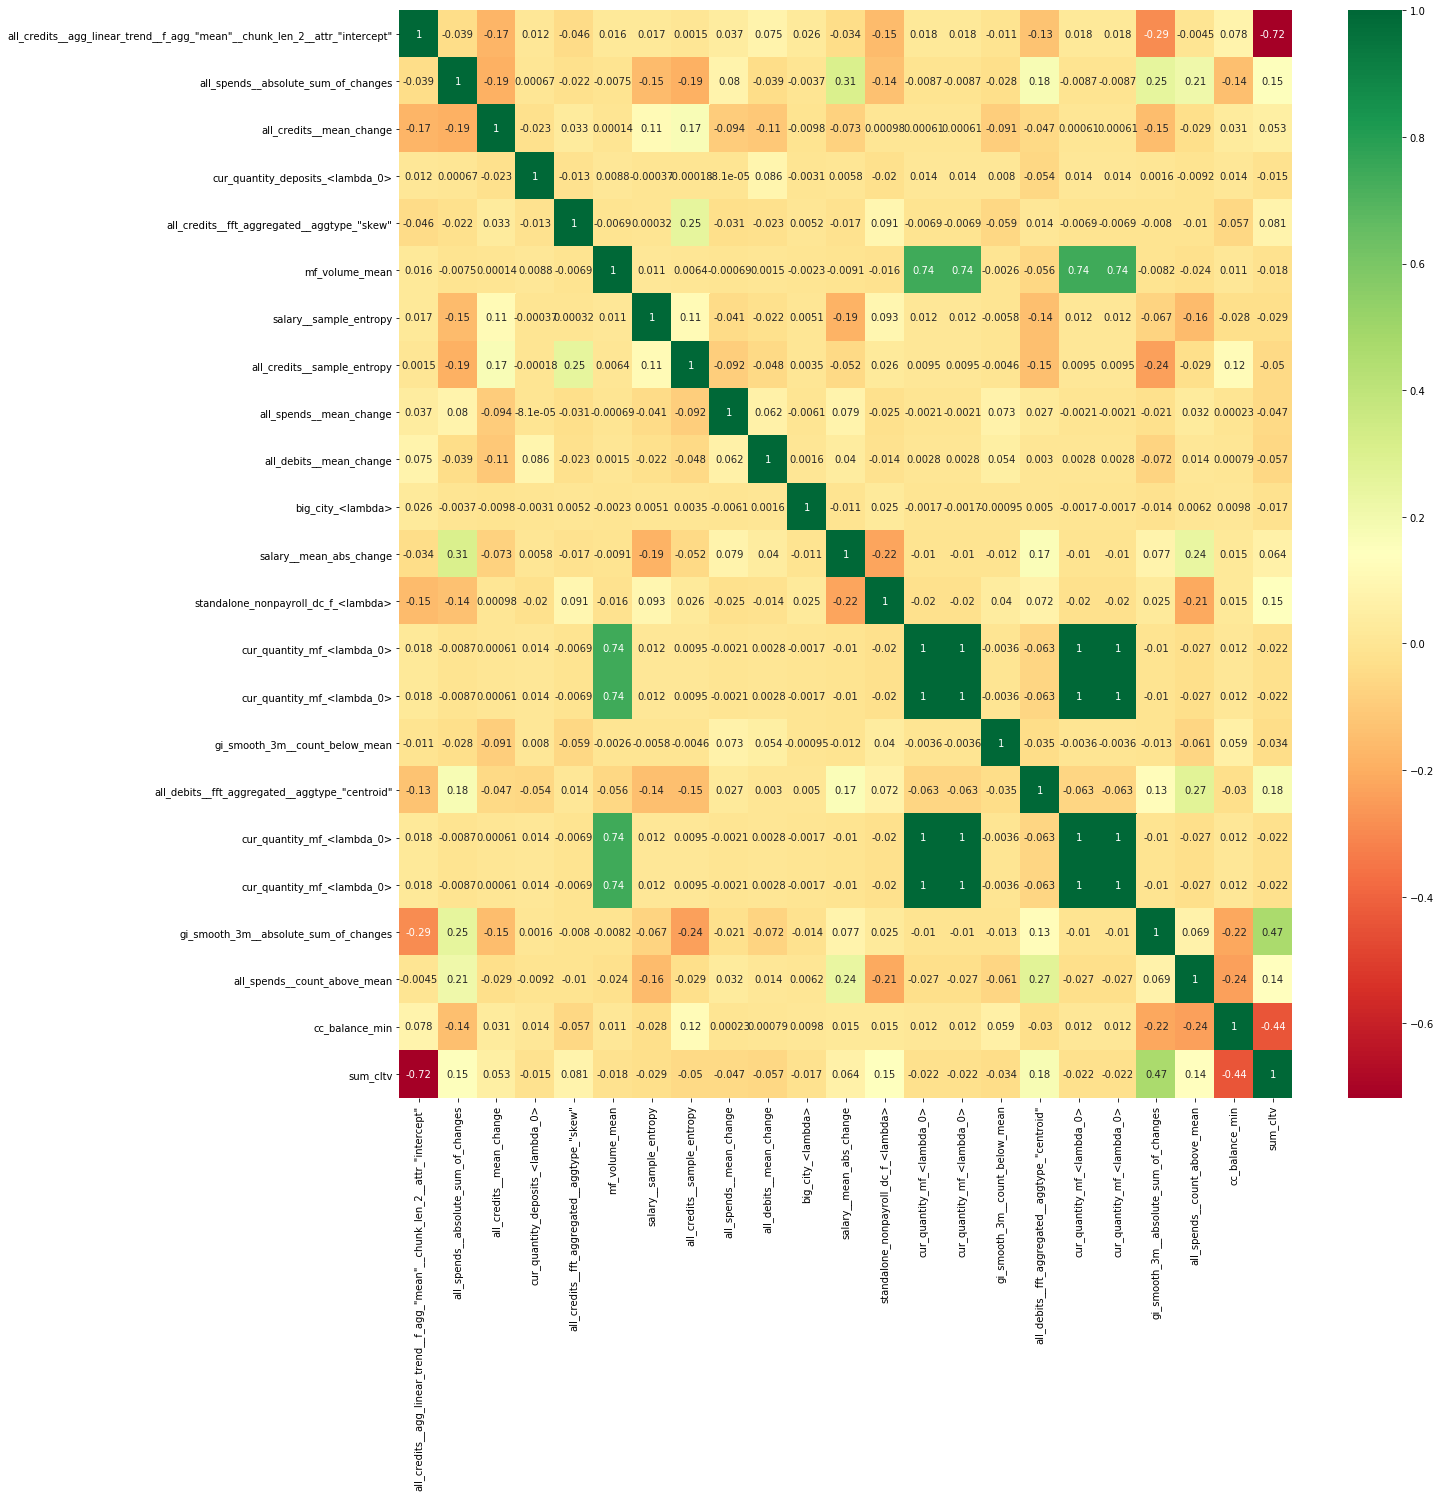

In [384]:
data = dataset_res.drop('sum_cltv', axis=1)\
    .iloc[:,np.random.randint(0, dataset_res.shape[1] - 2, size=20)]
data['sum_cltv'] = dataset_res['sum_cltv']
X = data.iloc[:,:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Обработка тестовых данных

In [0]:
from tsfresh import feature_extraction, extract_features
from tsfresh.feature_selection import relevance, select_features
from tsfresh.utilities.dataframe_functions import impute
# Импорты для преобразования текстовых переменных в лэйблы
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

!!! Надеюсь вы прочитаете это и вам будет стыдно, за то, что вы сохранили тестовые данные в одной кодировке, а трэйновые в другой

In [0]:
# Код для перекодирования из кирилицы в utf-8
# with open(path + '/CUP_IT_test_data.csv', 'r', encoding='cyrillic') as inp:
#   with open(path + '/CUP_IT_test_data_utf.csv', 'w', encoding='utf16') as out:
#     for i, line in enumerate(inp):
#       print(line)
#       if i == 250:
#         break

В итоге нашолся старый датасет с колонкой ранк, аве облачным технологиям

In [0]:
# loading train data to DataFrame
test = pd.read_csv(path + '/CUP_IT_test_data.csv', comment='#')

In [398]:
test = test.drop('rank', axis=1)
test.head()

,cif_id,dlk_cob_date,gi_smooth_3m,big_city,cu_gender,cu_education_level,cu_empl_area,cu_empl_level,payroll_f,cur_quantity_pl,cur_quantity_mort,cur_quantity_cc,cur_quantity_deposits,cur_quantity_dc,cur_quantity_accounts,cur_quantity_saccounts,cur_quantity_mf,cc_balance,cl_balance,ml_balance,pl_balance,td_volume,ca_volume,sa_volume,mf_volume,dc_cash_spend_v,dc_cash_spend_c,cc_cash_spend_v,cc_cash_spend_c,dc_pos_spend_v,dc_pos_spend_c,cc_pos_spend_v,cc_pos_spend_c,ca_f,rc_session_qnt_cur_mon,cur_qnt_sms,active,standalone_dc_f,standalone_payroll_dc_f,standalone_nonpayroll_dc_f,salary,cu_age,cu_mob,cu_empl_cur_dur_m,is_married,cu_eduaction_level
0,50514,2018-06-30,17.898438,OTH,1,03. Высшее,ДРУГОЕ,SUPPORT STAFF,0,1,0,0,0,1,2,0,0,NaN,NaN,NaN,-2182.57200,NaN,23.05368,NaN,NaN,0.0,0,0.0,0,0.0,0,0.0,0,1,3,-100.0,1,1,0,1,960.0,48.0,83,63.0,1,3
1,50514,2018-02-28,24.355419,OTH,1,03. Высшее,ДРУГОЕ,SUPPORT STAFF,0,1,0,0,0,1,2,0,0,NaN,NaN,NaN,-3210.81288,NaN,3.11064,NaN,NaN,0.0,0,0.0,0,0.0,0,0.0,0,1,3,-100.0,1,1,0,1,960.0,47.0,79,59.0,1,3
2,50514,2018-04-30,20.534134,OTH,1,03. Высшее,ДРУГОЕ,SUPPORT STAFF,0,1,0,0,0,1,2,0,0,NaN,NaN,NaN,-2703.79896,NaN,13.08216,NaN,NaN,0.0,0,0.0,0,0.0,0,0.0,0,1,4,-100.0,1,1,0,1,960.0,48.0,81,61.0,1,3
3,50514,2018-01-31,26.477938,OTH,1,03. Высшее,ДРУГОЕ,SUPPORT STAFF,0,1,0,0,0,1,2,0,0,NaN,NaN,NaN,-3462.84264,NaN,19.72488,NaN,NaN,0.0,0,0.0,0,0.0,0,0.0,0,1,2,-100.0,1,1,0,1,960.0,47.0,78,58.0,1,3
4,50514,2018-05-31,19.623962,OTH,1,03. Высшее,ДРУГОЕ,SUPPORT STAFF,0,1,0,0,0,1,2,0,0,NaN,NaN,NaN,-2445.49896,NaN,30.06792,NaN,NaN,0.0,0,0.0,0,0.0,0,0.0,0,1,1,-100.0,1,1,0,1,960.0,48.0,82,62.0,1,3


In [0]:
test['dlk_cob_date'] = pd.to_datetime(test['dlk_cob_date'])
# Сортировка 
test.sort_values(['cif_id', 'dlk_cob_date'], inplace=True)

## Заполним все НаНы

In [400]:
fill_bank_na(test)

Удаленные отрасли:
['услуги перевода' 6]
['автомобилестроение' 6]
['Ценные бумаги' 6]
['охранная' 6]
['Финансы и аудит' 6]
['Фармацевтическая промышленность' 6]
['ФИНАНСЫ, УПРАВЛЯЮЩИЕ КОМПАНИИ, БАНКИ' 6]
['Торговля (детское питание)' 6]
['ТУРИЗМ, РАЗВЛЕЧЕНИЯ, РЕСТОРАННЫЙ БИЗНЕС' 6]
['оценочная деятельность' 6]
['транспортно-экспедит.' 6]
['производство и поставка фасованных круп' 6]
['СПТУ №39' 6]
['аудит и консалтинг' 6]
['Проектирование, монтаж, ОПС, СКУД, видеоснабжение' 6]
['РСР' 6]
['сбалансированное питание' 6]
['Водоснабжение' 6]
['Гос. управление' 6]
['торгово-посредническая деятельность' 6]
['строительство дорог' 6]
['Другое Охранная система' 6]
['снабжение' 6]
['Платежные терминалы' 6]
['Инвестиционная' 6]
['бытовые услуги населению' 6]
['Медицинские услуги' 6]
['НАУКА, ОБРАЗОВАНИЕ' 6]
['ресторан' 6]
['Охрана и безопасность' 6]
['рекламное агенство' 6]
['Индустрия салонного бизнеса' 6]
['СТРОИТЕЛЬСТВО, НЕДВИЖИМОСТЬ' 18]
Удалено 33 отраслей.
Осталось: 15 отраслей.
Удаленные на

In [401]:
search_nan(test)

Роскошно, нанов нет!


0

## Агрегация данных

In [0]:
test_data = test

In [404]:
test.cif_id.nunique()

113962

In [0]:
# Теперь агрегируем все данные для обучающей выборки
test_data = test_data\
                        .drop(useless_feats, axis=1)\
                        .groupby('cif_id', as_index=False)\
                        .agg({#'dlk_cob_date': [last, 'max', 'min', 'count'],
                              'gi_smooth_3m': ['mean', 'sum'],
                              'big_city': [last,],
                              'cu_gender': [last],
                              'payroll_f': [last],
                              'cur_quantity_pl': [last],
                              'cur_quantity_mort': [last, 'mean'],
                              'cur_quantity_cc': [last, 'mean'],
                              'cur_quantity_deposits': [last, 'mean'],
                              'cur_quantity_dc': [last, 'mean'],
                              'cur_quantity_accounts': [last, 'mean'],
                              'cur_quantity_saccounts': [last, 'mean'],
                              'cur_quantity_mf': [last, 'mean'],
                              'cc_balance': balance_agg_funcs,
                              'cl_balance': credits_agg_funcs,
                              'ml_balance': credits_agg_funcs,
                              'pl_balance': credits_agg_funcs,
                              'td_volume': deposit_agg_funcs,
                              'ca_volume': deposit_agg_funcs,
                              'sa_volume': deposit_agg_funcs,
                              'mf_volume': deposit_agg_funcs,
                              'dc_cash_spend_v': cards_spend_agg_funcs,
                              'dc_cash_spend_c': cards_count_agg_funcs,
                              'cc_cash_spend_v': cards_spend_agg_funcs,
                              'cc_cash_spend_c': cards_count_agg_funcs,
                              'dc_pos_spend_v': cards_spend_agg_funcs,
                              'dc_pos_spend_c': cards_count_agg_funcs,
                              'cc_pos_spend_v': cards_spend_agg_funcs,
                              'cc_pos_spend_c': cards_count_agg_funcs,
                              'ca_f': categorical_agg_func,
                              'rc_session_qnt_cur_mon': [last, 'mean'],
                              'cur_qnt_sms': ['mean'],
                              'active': [last, 'mean'],
                              'standalone_dc_f': [last],
                              'standalone_payroll_dc_f': categorical_agg_func,
                              'standalone_nonpayroll_dc_f': categorical_agg_func,
                              'salary': balance_agg_funcs,
                              'cu_age': age_agg_funcs,
                              'cu_mob': [last],
                              'cu_empl_cur_dur_m': [last],
                              'is_married': categorical_agg_func,
                              'cu_eduaction_level': categorical_agg_func,
                              'cu_education_level': categorical_agg_func,
                              'cu_empl_area': categorical_agg_func,
                              'cu_empl_level': categorical_agg_func
                              })

In [406]:
test_data.columns = ["_".join(x) for x in test_data.columns.ravel()]
test_data.shape

(113962, 70)

In [0]:
# Инициализация анализатора
morph = pymorphy2.MorphAnalyzer()

In [0]:
for obj in test_data:
  data = list()
  if obj in obj_columns:
    test_data['temp'] = test_data[obj].apply(lambda x: morph.parse(str(x))[0].normal_form)
    enc = preprocessing.OrdinalEncoder()
    enc.fit(test_data['temp'].values.reshape(-1, 1))
    test_data[obj] = enc.transform(test_data['temp'].values.reshape(-1, 1))[:, 0]

In [0]:
test_data = test_data.drop('temp', axis=1)

In [410]:
test_data = test_data.rename({'cif_id_': 'cif_id'}, axis=1)
test_data.head(5)

,cif_id,gi_smooth_3m_mean,gi_smooth_3m_sum,big_city_<lambda>,cu_gender_<lambda>,payroll_f_<lambda>,cur_quantity_pl_<lambda>,cur_quantity_mort_<lambda_0>,cur_quantity_mort_mean,cur_quantity_cc_<lambda_0>,cur_quantity_cc_mean,cur_quantity_deposits_<lambda_0>,cur_quantity_deposits_mean,cur_quantity_dc_<lambda_0>,cur_quantity_dc_mean,cur_quantity_accounts_<lambda_0>,cur_quantity_accounts_mean,cur_quantity_saccounts_<lambda_0>,cur_quantity_saccounts_mean,cur_quantity_mf_<lambda_0>,cur_quantity_mf_mean,cc_balance_mean,cc_balance_max,cc_balance_min,cl_balance_<lambda_0>,cl_balance_max,ml_balance_<lambda_0>,ml_balance_max,pl_balance_<lambda_0>,pl_balance_max,td_volume_mean,td_volume_max,ca_volume_mean,ca_volume_max,sa_volume_mean,sa_volume_max,mf_volume_mean,mf_volume_max,dc_cash_spend_v_mean,dc_cash_spend_v_max,dc_cash_spend_c_mean,cc_cash_spend_v_mean,cc_cash_spend_v_max,cc_cash_spend_c_mean,dc_pos_spend_v_mean,dc_pos_spend_v_max,dc_pos_spend_c_mean,cc_pos_spend_v_mean,cc_pos_spend_v_max,cc_pos_spend_c_mean,ca_f_<lambda>,rc_session_qnt_cur_mon_<lambda_0>,rc_session_qnt_cur_mon_mean,cur_qnt_sms_mean,active_<lambda_0>,active_mean,standalone_dc_f_<lambda>,standalone_payroll_dc_f_<lambda>,standalone_nonpayroll_dc_f_<lambda>,salary_mean,salary_max,salary_min,cu_age_<lambda>,cu_mob_<lambda>,cu_empl_cur_dur_m_<lambda>,is_married_<lambda>,cu_eduaction_level_<lambda>,cu_education_level_<lambda>,cu_empl_area_<lambda>,cu_empl_level_<lambda>
0,1000,53.940459,323.642757,1.0,0,0,1,0,0.0,2,2.500000,0,0.0,1,1.000000,1,1.0,0,0.0,0,0.0,-190.73664,-0.00984,-599.18208,0.0,0.0,0.0,0.0,-5612.09448,-5612.09448,0.0,0.0,20.36652,77.67048,0.0000,0.00000,0.0,0.0,864.0,3600.0,1.166667,0.0,0.0,0.0,224.79672,508.65000,11.000000,26.85384,80.62704,1.333333,1,2,7.000000,1.833333,1,1.000000,1,0,1,203.65600,242.424,173.32800,33.0,122,29.0,1,3,2.0,9.0,6.0
1,1003,75.117063,450.702379,3.0,1,0,1,0,0.0,2,1.666667,0,0.0,1,1.500000,2,2.0,0,0.0,0,0.0,-1073.62020,1.22496,-2265.40992,0.0,0.0,0.0,0.0,-7311.50568,-6565.72296,0.0,0.0,40.41964,215.84496,0.0000,0.00000,0.0,0.0,3.2,19.2,0.166667,0.0,0.0,0.0,118.97720,556.80000,3.333333,678.30888,2062.90320,8.833333,1,34,28.666667,0.500000,1,1.000000,0,0,0,1621.54472,1848.000,993.26832,35.0,30,6.0,1,3,2.0,2.0,8.0
2,1006,2.433070,14.598418,0.0,0,0,0,0,0.0,0,0.000000,0,0.0,0,0.333333,1,1.0,0,0.0,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,1.79600,10.69536,0.0000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,1,0,0.000000,0.333333,0,0.333333,0,0,0,720.00000,720.000,720.00000,44.0,62,97.0,1,2,1.0,2.0,2.0
3,1008,1.346990,8.081938,1.0,0,0,0,0,0.0,0,0.000000,0,0.0,0,0.000000,1,1.0,1,0.5,0,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00120,0.00120,5.1482,10.33488,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,1,0,0.333333,0.000000,1,0.833333,0,0,0,1684.49400,1684.494,1684.49400,35.0,50,63.0,1,3,2.0,2.0,8.0
4,1012,7.442803,44.656817,2.0,0,0,0,0,0.0,2,2.000000,0,0.0,1,1.000000,1,1.0,1,1.0,0,0.0,-7.35400,3.87600,-48.00000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,12.06524,37.05648,114.5900,348.44424,0.0,0.0,110.4,367.2,2.500000,0.0,0.0,0.0,133.46280,306.21672,15.166667,33.20620,104.08800,3.166667,1,3,9.166667,1.000000,1,1.000000,0,0,0,720.00000,720.000,720.00000,32.0,26,28.0,0,3,2.0,10.0,11.0


In [411]:
test_data.shape

(113962, 70)

Генерация признаков для тестовой выборки

In [0]:
# Оставим нужные фичи, которые изменяются во временем
main_feats = [
             'cif_id',
             'dlk_cob_date'
]
# Не фартануло, слишком много данных, колаб лег, будем объединять
time_series_feats = [
                     
                     'gi_smooth_3m',
                    #  'cc_balance',
                    #  'cl_balance',
                    #  'ml_balance',
                    #  'pl_balance',
                    #  'td_volume',
                    #  'ca_volume',
                    #  'sa_volume',
                    #  'mf_volume',
                    #  'dc_cash_spend_v',
                    #  'cc_cash_spend_v',
                    #  'dc_pos_spend_v',
                    #  'cc_pos_spend_v',
                    #  'rc_session_qnt_cur_mon',
                    #  'cur_qnt_sms',
                     'salary'
]

Самая сложная часть, надо не промахнуться и сгенерировать те же признаки, алгоритм:
  - Запускаем поиск фичей, без селекции
  - Объединяев все фичи
  - Оставляем лишь фичи лежащие в relevant_features (список или файл, по желанию)

In [413]:
#
additional_features = pd.DataFrame(test_data.iloc[:,0])
additional_features.shape

(113962, 1)

In [414]:
# Объединим все фичи и внесем колонки в список time_series_feats
time_series_feats.append(merge_spends(test))
time_series_feats.append(merge_credits(test))
time_series_feats.append(merge_debits(test))
# time_series_feats.append(merge_actions(test))
time_series_feats

Создана колонка all_spends
Создана колонка all_credits
Создана колонка all_debits


['gi_smooth_3m', 'salary', 'all_spends', 'all_credits', 'all_debits']

In [0]:
test_data['age_category'] = test_data['cu_age_<lambda>'].apply(get_age_category)

In [417]:
test_light = test.loc[:,[*main_feats, *time_series_feats]]
test_light.index = np.arange(test_light.shape[0])
test_light

,cif_id,dlk_cob_date,gi_smooth_3m,salary,all_spends,all_credits,all_debits
0,1000,2018-01-31,53.184058,188.232000,639.18504,-6401.02080,7.91160
1,1000,2018-02-28,47.592137,242.424000,100.54944,-6241.80096,1.00536
2,1000,2018-03-31,40.828960,173.328000,118.76160,-6089.32536,3.40848
3,1000,2018-04-30,35.967168,223.728000,26.11200,-5956.79664,-1.39848
4,1000,2018-05-31,61.794418,173.328000,4024.37328,-6294.35280,33.60168
...,...,...,...,...,...,...,...
683767,511531,2018-02-28,74.185430,1017.910440,0.00000,-12597.55632,4.95360
683768,511531,2018-03-31,72.694857,1017.910440,0.00000,-12374.88216,9.18360
683769,511531,2018-04-30,70.685762,1017.910440,0.00000,-12143.75304,13.41360
683770,511531,2018-05-31,73.010428,1056.417336,4800.00000,-17944.77048,506.71560


In [418]:
n = 10000
# relevant_features = list()
# Generating features for all time-series along because of big train data
for time_series_column in time_series_feats:
  veritas_tempus = extract_features(test_light\
                                   .loc[:,[*main_feats, time_series_column]],
                                    column_id='cif_id',
                                    column_sort='dlk_cob_date',
                                    n_jobs=8,
                                    default_fc_parameters=fc_parametrs)
  sum_1 = veritas_tempus.columns.shape[0]
  impute(veritas_tempus)
  # features_filtered = select_features(veritas_tempus,
                                    # y=dataset_test['sum_cltv'])
  # sum_2 = features_filtered.columns.shape[0]
  print(f"Создано {sum_1} фичей, добавлено в список фичей")
        # f" {sum_1 - sum_2} фичей для {time_series_column} столбца.")
  # Запись в файл, на случай если усну или не доживу
  # features_filtered.to_csv(f'drive/My Drive/hack/changelenge/'
  #                          f'time-series_features/{time_series_column}.csv')
  # print(f'Успешно записаны фичи: drive/My Drive/hack/changelenge/'
  #                          f'time-series_features/{time_series_column}.csv')
  # Добавление в отдельный датафрэйм с фичами
  additional_features = additional_features.merge(veritas_tempus,
                            left_on='cif_id', right_index=True)
  # Запись названия фичей, не знаю зачем
  # relevant_features.extend(features_filtered.columns)
  # del veritas_tempus
  # del features_filtered


Feature Extraction: 100%|██████████| 40/40 [01:14<00:00,  1.26it/s]
/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['gi_smooth_3m__agg_linear_trend__f_agg_"mean"__chunk_len_6__attr_"slope"'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Создано 17 фичей, добавлено в список фичей



Feature Extraction: 100%|██████████| 40/40 [01:11<00:00,  1.01it/s]
/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['salary__agg_linear_trend__f_agg_"mean"__chunk_len_6__attr_"slope"'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Создано 17 фичей, добавлено в список фичей



Feature Extraction: 100%|██████████| 40/40 [01:14<00:00,  1.34it/s]
/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['all_spends__agg_linear_trend__f_agg_"mean"__chunk_len_6__attr_"slope"'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Создано 17 фичей, добавлено в список фичей



Feature Extraction: 100%|██████████| 40/40 [01:13<00:00,  1.20it/s]
/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['all_credits__agg_linear_trend__f_agg_"mean"__chunk_len_6__attr_"slope"'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Создано 17 фичей, добавлено в список фичей



Feature Extraction: 100%|██████████| 40/40 [01:17<00:00,  1.12it/s]
/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:170: RuntimeWarning: The columns ['all_debits__agg_linear_trend__f_agg_"mean"__chunk_len_6__attr_"slope"'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Создано 17 фичей, добавлено в список фичей


In [419]:
additional_features.shape

(113962, 86)

In [0]:
relevant_features = list()
with open(path + 'relevant_features.txt', 'r') as f:
  for line in f:
    line = line.replace('\n', '')
    # print(line)
    relevant_features.append(line)
relevant_features = np.array(relevant_features)

In [425]:
relevant_features

array(['gi_smooth_3m__absolute_sum_of_changes',
       'gi_smooth_3m__agg_linear_trend__f_agg_"mean"__chunk_len_1__attr_"slope"',
       'gi_smooth_3m__agg_linear_trend__f_agg_"mean"__chunk_len_2__attr_"intercept"',
       'gi_smooth_3m__agg_linear_trend__f_agg_"mean"__chunk_len_2__attr_"slope"',
       'gi_smooth_3m__fft_aggregated__aggtype_"centroid"',
       'gi_smooth_3m__fft_aggregated__aggtype_"skew"',
       'gi_smooth_3m__fft_aggregated__aggtype_"variance"',
       'gi_smooth_3m__mean_abs_change', 'gi_smooth_3m__mean_change',
       'gi_smooth_3m__sample_entropy', 'gi_smooth_3m__count_above_mean',
       'gi_smooth_3m__agg_linear_trend__f_agg_"mean"__chunk_len_1__attr_"pvalue"',
       'gi_smooth_3m__count_below_mean', 'gi_smooth_3m__skewness',
       'gi_smooth_3m__mean_second_derivative_central',
       'gi_smooth_3m__cid_ce__normalize_True',
       'salary__absolute_sum_of_changes',
       'salary__agg_linear_trend__f_agg_"mean"__chunk_len_1__attr_"pvalue"',
       'salary__

In [0]:
additional_features_temp = additional_features.loc[:,['cif_id',*relevant_features]]

In [0]:
del additional_features

In [436]:
additional_features_temp.shape

(113962, 77)

In [0]:
# Resulting test  dataset
test_result = test_data.merge(additional_features_temp, on='cif_id')

In [452]:
search_nan(test_result)

Роскошно, нанов нет!


0

In [0]:
del test
del test_data
del additional_features_temp

In [454]:
test_result.shape

(113962, 147)

In [0]:
# Write final test data in file
test_result.to_csv(path + 'test_data_preproc.csv')

# Here it goes ML

In [456]:
!pip install pymorphy2

import pandas as pd
import numpy as np
from numpy import isnan
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy2

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle as cPickle

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true[y_true == 0] = 0.0001
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
data = dataset_res

In [0]:
Y = data['sum_cltv']
data = data.drop(['sum_cltv'], axis=1)
data = data.drop(['mean_month_cltv'], axis=1)
data['sum_cltv'] = Y
data = data.values

In [461]:
def show_map(df_te_train):
  data1 = df_te_train.copy()
  corrmat = pd.DataFrame(data1).corr()
  top_corr_features = corrmat.index
  plt.figure(figsize=(20,20))
  #plot heat map
  #print(data1[top_corr_features].shape)
  g=sns.heatmap(data1[top_corr_features].corr().abs(),annot=True,cmap="RdYlGn")


show_map(data)


AttributeError: ignored

<Figure size 1440x1440 with 0 Axes>

## Train_test_split

In [463]:
X, x_, Y, y_ = train_test_split(data[:, :-1], data[:, -1], shuffle=True, test_size=0.2)
print(X.shape)
print(Y.shape)

(239752, 147)
(239752,)


# ***Models***

# GradientBoostingRegressor

*Test only one model*

In [462]:
gbr = GradientBoostingRegressor(n_estimators=150, max_depth=7)
gbr.fit(X, Y)
print(mean_absolute_error(Y, gbr.predict(X)))
print(mean_absolute_error(y_, gbr.predict(x_)))
print(mape(Y, gbr.predict(X)))
print(mape(y_, gbr.predict(x_)))


# save the classifier
with open('/content/drive/My Drive/Colab Notebooks/bank_hack/my_regres.pkl', 'wb') as fid:
    cPickle.dump(gbr, fid)

40.964803293112695


NameError: ignored

*Test all models*

In [0]:
kf = KFold(n_splits=10, shuffle=True)
gbrs = []
final = 0
pred = 0
i = 0

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  gbr = GradientBoostingRegressor(n_estimators=150, max_depth=7)
  gbr.fit(X_train, y_train)
  final += mean_absolute_error(y_test, gbr.predict(X_test))
  i += 1
  pred += mape(y_, gbr.predict(x_))
  print("curr score:", final / i, "curr pred score:", pred / i)
  with open(f'/content/drive/My Drive/Colab Notebooks/bank_hack/my_regres_{i}.pkl', 'wb') as fid:
    cPickle.dump(gbr, fid)  


print("final score:\n", final / i)

# LinearRegression

In [0]:
kf = KFold(n_splits=10, shuffle=True)
gbrs = []
final = 0
pred = 0
i = 0

for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  gbr = LinearRegression()
  gbr.fit(X_train, y_train)
  final += mean_absolute_error(y_test, gbr.predict(X_test))
  i += 1
  pred += mape(y_, gbr.predict(x_))  # mean_absolute_error(y_, gbr.predict(x_))
  print("curr score:", final / i, "curr pred score:", pred / i)
  with open(f'/content/drive/My Drive/Colab Notebooks/bank_hack/my_regres_{i + 10}.pkl', 'wb') as fid:
    cPickle.dump(gbr, fid)  


print("final score:\n", final / i)

In [0]:
data1 = test_result
# data1 = data1.drop(['sum_cltv'], axis=1)
# data1 = data1.drop(['mean_month_cltv'], axis=1)
# print(data1.columns.values)
data1 = data1.values
print(data1.shape)

# Make prediction

In [464]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


res = []

def check_model(path):
  with open(path, 'rb') as fid:
    m = cPickle.load(fid)
  #print("MAE:\ntrain:", mean_absolute_error(Y, m.predict(X)), "test:", mean_absolute_error(y, m.predict(x)))
  #print("MAPE:\ntrain:", mape(Y, m.predict(X)), "test:", mape(y, m.predict(x)))
  res.append(m.predict(data1))


for i in range(10):
  # print(f"Model №{i}")
  check_model(f'/content/drive/My Drive/Colab Notebooks/bank_hack/my_regres_{i}.pkl')

res = np.asarray(res)
res = res.mean(axis=0)
# print(res.shape)

tmp = res
tmp = tmp
# print(tmp)

data_ = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bank_hack/test_data_preproc.csv", comment="#")
# print(data_['cif_id'].values)

# print(tmp)


df = pd.DataFrame({'cif_id': data_['cif_id'].values, 'sum_cltv': tmp})
print(df)

df.to_csv("/content/drive/My Drive/Colab Notebooks/bank_hack/CUP_IT_predictions.csv",
          index=False)

FileNotFoundError: ignored